In [82]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss

seed = 1234
np.random.seed(seed)

In [5]:
df = pd.read_csv("numerai_training_data.csv")
df.head()

,id,era,data_type,feature1,feature2,feature3,feature4,feature5,feature6,feature7,...,feature13,feature14,feature15,feature16,feature17,feature18,feature19,feature20,feature21,target
0,119763,era1,train,0.28305,0.52361,0.69209,0.44205,0.43505,0.76235,0.31014,...,0.30291,0.56754,0.41035,0.30540,0.70217,0.67645,0.33197,0.62004,0.40567,0
1,45906,era1,train,0.72306,0.55033,0.39225,0.63030,0.56429,0.33871,0.48310,...,0.63850,0.44519,0.40625,0.63020,0.36515,0.39648,0.49776,0.37858,0.41617,1
2,139896,era1,train,0.29881,0.48360,0.74775,0.35139,0.34590,0.59046,0.47939,...,0.25399,0.69524,0.54931,0.24025,0.73879,0.74283,0.46221,0.61501,0.44855,0
3,116826,era1,train,0.51999,0.62361,0.55290,0.53790,0.45459,0.48424,0.55901,...,0.45956,0.64501,0.63455,0.41849,0.53119,0.54691,0.58776,0.39615,0.32122,1
4,28656,era1,train,0.47968,0.56531,0.58870,0.44709,0.43121,0.48611,0.53326,...,0.41466,0.63677,0.53184,0.41226,0.57170,0.60222,0.48431,0.50111,0.40677,1


In [6]:
df_test = pd.read_csv("numerai_tournament_data.csv")
df_test.head()

,id,era,data_type,feature1,feature2,feature3,feature4,feature5,feature6,feature7,...,feature13,feature14,feature15,feature16,feature17,feature18,feature19,feature20,feature21,target
0,55113,era97,validation,0.56211,0.48552,0.61290,0.39826,0.37009,0.41959,0.67384,...,0.42825,0.70212,0.60207,0.41624,0.56321,0.62616,0.62193,0.49730,0.51432,1.0
1,9835,era97,validation,0.50865,0.60490,0.52614,0.53751,0.51433,0.66610,0.43490,...,0.48310,0.53141,0.46809,0.46428,0.51586,0.52340,0.43596,0.47253,0.38056,1.0
2,150614,era97,validation,0.50124,0.46113,0.60613,0.43473,0.42881,0.52306,0.49339,...,0.42181,0.57629,0.44828,0.41719,0.58024,0.60782,0.46928,0.55603,0.51480,1.0
3,80064,era97,validation,0.42507,0.43184,0.67858,0.33142,0.36523,0.48837,0.52327,...,0.33598,0.64555,0.44551,0.35940,0.65535,0.69759,0.42920,0.63423,0.55336,0.0
4,116911,era97,validation,0.45803,0.60370,0.49455,0.57237,0.59102,0.66634,0.26381,...,0.48764,0.41904,0.34250,0.46747,0.51608,0.48878,0.31060,0.50326,0.33420,0.0


In [7]:
features = [f for f in list(df) if "feature" in f]

X = df[features]
Y = df["target"]

x_crossval = df_test[features].loc[df_test["data_type"] == "validation"]
id_crossval = df_test["target"].loc[df_test["data_type"] == "validation"]

x_test = df_test[features].loc[df_test["data_type"] == "test"]

x_live = df_test[features].loc[df_test["data_type"] == "live"]

x_predict = df_test[features]
ids = df_test["id"]

In [8]:
def create_model():
    # create model
    model = Sequential()
    model.add(Dense(64, input_dim=21, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(64, input_dim=21, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

model = KerasClassifier(build_fn=create_model, batch_size=512, epochs=20, verbose=0)

In [ ]:
model.fit(X.as_matrix(), Y)

In [100]:
predictions = model.predict(x_crossval.as_matrix())
predictions_probability = model.predict_proba(x_crossval.as_matrix())
accuracy = accuracy_score(id_crossval, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
logloss = log_loss(id_crossval, predictions_probability)
print("Logloss: %f" % (logloss))

Accuracy: 51.48%
Logloss: 0.692560


In [11]:
sum(model.predict(x_crossval.as_matrix()))/sum(x_crossval["feature1"].value_counts())

array([ 0.5973271])

In [128]:
y_predict = model.predict_proba(x_predict.as_matrix())
results = y_predict[:,1]
results_df = pd.DataFrame(data={'probability':results})
joined = pd.DataFrame(ids).join(results_df)
joined.head()

,id,probability
0,55113,0.512742
1,9835,0.505853
2,150614,0.516292
3,80064,0.519050
4,116911,0.501924


In [129]:
joined.to_csv("predictions2.csv", index=False)

# What else can we tune in the neural network?
# Once we have tuned the NN, moved on to XGBoost, to see if we can pick anything out from the features

In [14]:
from xgboost import XGBClassifier

In [102]:
gb_model = XGBClassifier(max_depth=1)
gb_model.fit(X, Y)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=1,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [103]:
predictions = gb_model.predict(x_crossval)
predictions_probability = gb_model.predict_proba(x_crossval)
accuracy = accuracy_score(id_crossval, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
logloss = log_loss(id_crossval, predictions_probability)
print("Logloss: %f" % (logloss))

Accuracy: 51.43%
Logloss: 0.692569


In [67]:
for i in range(0, len(gb_model.feature_importances_)):
    print(list(X)[i], " = ", gb_model.feature_importances_[i])

feature1  =  0.0
feature2  =  0.0
feature3  =  0.02
feature4  =  0.02
feature5  =  0.05
feature6  =  0.07
feature7  =  0.1
feature8  =  0.0
feature9  =  0.02
feature10  =  0.13
feature11  =  0.01
feature12  =  0.09
feature13  =  0.0
feature14  =  0.0
feature15  =  0.09
feature16  =  0.1
feature17  =  0.01
feature18  =  0.0
feature19  =  0.12
feature20  =  0.1
feature21  =  0.07


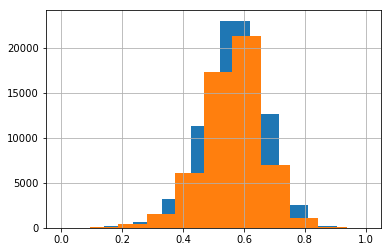

In [49]:
%matplotlib inline
df["feature10"].loc[df["target"] == 0].hist()
df["feature10"].loc[df["target"] == 1].hist()

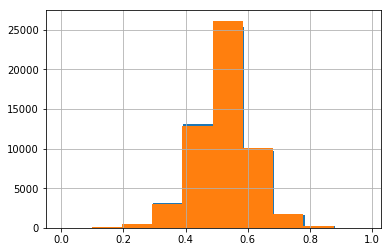

In [50]:
df["feature19"].loc[df["target"] == 0].hist()
df["feature19"].loc[df["target"] == 1].hist()

In [119]:
eng_feature1 = df["feature10"] * df["feature19"]
eng_feature1 = pd.DataFrame(data={'eng_feature1':eng_feature1})
eng_X = pd.DataFrame(X).join(eng_feature1)

gb_model = XGBClassifier(max_depth=1)
gb_model.fit(eng_X, Y)

eng_feature1 = x_crossval["feature10"] * x_crossval["feature19"]
eng_feature1 = pd.DataFrame(data={'eng_feature1':eng_feature1})
eng_crossval = pd.DataFrame(x_crossval).join(eng_feature1)

predictions = gb_model.predict(eng_crossval)
predictions_probability = gb_model.predict_proba(eng_crossval)
accuracy = accuracy_score(id_crossval, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
logloss = log_loss(id_crossval, predictions_probability)
print("Logloss: %f" % (logloss))

Accuracy: 51.55%
Logloss: 0.692486


In [120]:
for i in range(0, len(gb_model.feature_importances_)):
    print(list(eng_X)[i], " = ", gb_model.feature_importances_[i])

feature1  =  0.0
feature2  =  0.0
feature3  =  0.01
feature4  =  0.02
feature5  =  0.02
feature6  =  0.09
feature7  =  0.11
feature8  =  0.01
feature9  =  0.01
feature10  =  0.1
feature11  =  0.03
feature12  =  0.04
feature13  =  0.0
feature14  =  0.02
feature15  =  0.04
feature16  =  0.05
feature17  =  0.01
feature18  =  0.0
feature19  =  0.1
feature20  =  0.07
feature21  =  0.09
eng_feature1  =  0.18


In [124]:
eng_feature2 = df["feature6"] * df["feature21"]
eng_feature2 = pd.DataFrame(data={'eng_feature2':eng_feature2})
eng_X_2 = pd.DataFrame(eng_X).join(eng_feature2)

gb_model = XGBClassifier(max_depth=1)
gb_model.fit(eng_X_2, Y)

eng_feature2 = x_crossval["feature6"] * x_crossval["feature21"]
eng_feature2 = pd.DataFrame(data={'eng_feature2':eng_feature2})
eng_crossval_2 = pd.DataFrame(eng_crossval).join(eng_feature2)

predictions = gb_model.predict(eng_crossval_2)
predictions_probability = gb_model.predict_proba(eng_crossval_2)
accuracy = accuracy_score(id_crossval, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
logloss = log_loss(id_crossval, predictions_probability)
print("Logloss: %f" % (logloss))

Accuracy: 51.58%
Logloss: 0.692418


In [126]:
for i in range(0, len(gb_model.feature_importances_)):
    print(list(eng_X_2)[i], " = ", gb_model.feature_importances_[i])

feature1  =  0.0
feature2  =  0.0
feature3  =  0.01
feature4  =  0.04
feature5  =  0.03
feature6  =  0.03
feature7  =  0.1
feature8  =  0.01
feature9  =  0.02
feature10  =  0.07
feature11  =  0.01
feature12  =  0.04
feature13  =  0.0
feature14  =  0.02
feature15  =  0.04
feature16  =  0.05
feature17  =  0.01
feature18  =  0.0
feature19  =  0.09
feature20  =  0.09
feature21  =  0.08
eng_feature1  =  0.13
eng_feature2  =  0.13


In [131]:
eng_feature1 = x_predict["feature10"] * x_predict["feature19"]
eng_feature1 = pd.DataFrame(data={'eng_feature1':eng_feature1})
eng_X_predict = pd.DataFrame(x_predict).join(eng_feature1)
eng_feature2 = x_predict["feature6"] * x_predict["feature21"]
eng_feature2 = pd.DataFrame(data={'eng_feature2':eng_feature2})
eng_X_predict = pd.DataFrame(eng_X_predict).join(eng_feature2)


y_predict = gb_model.predict_proba(eng_X_predict)
results = y_predict[:,1]
results_df = pd.DataFrame(data={'probability':results})
joined = pd.DataFrame(ids).join(results_df)
joined.to_csv("predictions3.csv", index=False)

# Create some more features then feed the final df back into the NN. Not sure how I'll be able to achieve concordance...